<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 4b. VSS Workshop Part 2: Q&A and Graph-RAG

In the last lab, we learned how to use NVIDIA's [Video Search and Summarization AI Agent](https://build.nvidia.com/nvidia/video-search-and-summarization/blueprintcard) to summarize video. In this lab, we will explore how users can ask questions about video content to this AI agent.

#### Learning Objectives:
The goals of this notebook are to:
- Exploring Q&A on videos through VSS REST APIs
- Understanding Graph-RAG Components
- Visualizing knowledge graph in Neo4J
- Q&A with Vector-RAG (no Graph-RAG)

## Q&A with VSS

VSS supports Question-Answering (Q&A) functionality via **Vector-RAG** and **Graph-RAG**. Vector-RAG is the only supported method for live stream processing. And Graph-RAG is specifically designed for video-based queries.

**Q&A with Vector-RAG:** Captions generated by the VLM, along with their embeddings, are stored in Milvus DB. Given a query, the top five most relevant chunks are retrieved, re-ranked using ```llama-3.2-nv-rerankqa-1b-v2```, and passed to a LLM to generate the final answer.

**Q&A with Graph-RAG:** To capture the complex information produced by the VLM, a knowledge graph is built and stored during video ingestion. Use an LLM to convert the dense captions in a set of nodes, edges, and associated properties. This knowledge graph is stored in a graph database. Captions and embeddings, generated with ```llama-3.2-nv-embedqa-1b-v2```, are also linked to these entities. By using Graph-RAG techniques, an LLM can access this information to extract key insights for Q&A.

![VSS CA-RAG Diagram](images/VSS_CA-RAG.png)

## 4.1 Setup Environment

We will be using the same VSS server as the previous lab. Let's verify that it is up and running.

In [1]:
warehouse_video = "data/warehouse.mp4"

In [2]:
host = "via-server" #e.g., 0.0.0.0 or localhost
port = "8000" #e.g., 8000

In [3]:
import requests
import yaml

vss_url = f"http://{host}:{port}"

ready_check_url = f"{vss_url}/health/ready"
response = requests.get(ready_check_url)

if response.status_code == 200:
    print(f"Service is ready.")
else:
    print(f"Service is not ready. Status code: {response.status_code}")

Service is ready.


## 4.2 Exploring Q&A on Videos

Please refer to the previous lab for exploring all REST API endpoints. Below we will use REST APIs to upload a file, start video processing with chat enabled, and then try out a few questions.

<!-- ![Warehouse Scene](images/warehouse.png) -->

<video width="1000 " height=" " 
       src="data/warehouse.mp4"  
       controls>
</video>

### 4.2.1 Upload Video File

Let's start by uploading a video and storing the file-id from the response.

In [4]:
upload_url = f"{vss_url}/files"
files = {'file': ('filename_with_extension', open(warehouse_video, 'rb'))}

response = requests.post(upload_url, data={'purpose': 'vision', 'media_type': 'video'}, files=files)

if response.status_code == 200:
    video_id=response.json().get('id')
    print("Video Uploaded")
    print(f"Video file ID: {video_id}")
else:
    print(f"Failed to upload file. Status code: {response.status_code}")

Video Uploaded
Video file ID: a2268081-5e7a-4997-a339-dca03c47f7e6


### 4.2.2 Ingest and Process Video

Next, let's process the video to generate dense captions and knowledge graph. This step can take a couple of minutes.
- First, we'll set the prompts
- Then, we'll call the summarize API to ingest the video
- Note that we set ```enable_chat``` to True to create the knowledge graph

In [5]:
prompts = {
    "vlm_prompt": "You are a warehouse monitoring system. Describe the events in this warehouse and look for any anomalies. "
                            "Start each sentence with start and end timestamp of the event.",
    
    "caption_summarization": "You will be given captions from sequential clips of a video. Aggregate captions in the format "
                             "start_time:end_time:caption based on whether captions are related to one another or create a continuous scene.",
    
    "summary_aggregation": "Based on the available information, generate a summary that captures the important events in the video. "
                           "The summary should be organized chronologically and in logical sections. This should be a concise, "
                           "yet descriptive summary of all the important events. The format should be intuitive and easy for a "
                           "user to read and understand what happened. Format the output in Markdown so it can be displayed nicely."
}

In [6]:
def process_video(prompts, video_id=video_id):
    
    process_video_url = f"{vss_url}/summarize"

    payload = {
        "id": video_id,
        "prompt": prompts['vlm_prompt'],
        "caption_summarization_prompt": prompts['caption_summarization'],
        "summary_aggregation_prompt": prompts['summary_aggregation'],
        "model": "vila-1.5",
        "chunk_duration": 10,
        "chunk_overlap_duration": 0,
        "summarize": False,
        "enable_chat": True,
    }

    try:
        response = requests.post(process_video_url, json=payload)
        
        if response.status_code == 200:
            response_data = response.json()
            # Extracting the summary content
            summary = response_data.get('choices', [])[0].get('message', {}).get('content', '')
            return summary if summary else "No content received."
        else:
            return f"Failed to summarize. Status code: {response.status_code}. Response: {response.text}"
    
    except requests.RequestException as e:
        return f"An error occurred: {e}"

In [7]:
process_video(prompts)

'Media processed'

### 4.2.3 Ask Questions

Once the video is processed, the ```/chat/completions``` endpoint can be called to ask a question

![Q&A endpoint](images/qna_swagger.png)

In [8]:
def qna(query, video_id=video_id):

    qna_url = f"{vss_url}/chat/completions"

    payload = {
        "id": video_id,
        "messages": [
            {
                "content": query,
                "role": "user",
            }
        ],
        "model": "vila-1.5"
    }

    try:
        response = requests.post(qna_url, json=payload)
        
        if response.status_code == 200:
            response_data = response.json()
            # Extracting the answer content
            answer = response_data.get("choices", [])[0].get("message", {}).get("content", "")
            return answer if answer else "No answer received."
        else:
            return f"Failed to get a response. Status code: {response.status_code}. Response: {response.text}"
    
    except requests.RequestException as e:
        return f"An error occurred: {e}"

In [9]:
qna("Was there any forklift in the scene?")

'Yes, there was a forklift in the scene. A forklift driver was seen driving the forklift down the aisle of the warehouse and then turning around.'

In [10]:
qna("Was the worker carrying the box wearing PPE?")

'Yes, the worker carrying the box was wearing personal protective equipment (PPE), including a high-visibility jacket.'

## 4.3 Understanding Graph-RAG Components

![GraphRAG Diagram](images/GraphRAG.png)

---

## 4.3.1 G-Extraction/Indexing

### Dense Captions to Graph Conversion:
The Graph Extractor uses an LLM to analyze dense captions or any text input and identify key entities, actions, and relationships within the text.

#### Example:
Given a warehouse video scene caption like:  
*"A worker places a heavy box on the conveyor belt, and the box falls due to improper placement."*

- The LLM can extract entities such as:
  - **Worker** (Person)
  - **Box** (Object)
  - **Conveyor Belt** (Equipment)

- Relationships identified might include:
  - **"Worker places box on conveyor belt"**
  - **"Box falls due to improper placement"**

These entities and relationships are represented as nodes and edges in a Neo4j graph. Captions and embeddings, generated with `nvidia/nv-embedqa-e5-v5`, are also linked to these entities. These can provide descriptive answers to user queries.


---

## 4.3.2 G-Retriever

### Cypher Query Generation:
The Graph Retriever leverages an LLM to process user queries and translate them into structured cypher queries suitable for graph-based searches.

#### Example:
If the user query is:  
*"What caused the box to fall?"*

- The LLM identifies the key entities (e.g., "box") and the desired information (e.g., cause of fall).  
- It then generates a structured cypher query for the graph:

```cypher
MATCH (b:Object)-[:PLACED_ON]->(c:Equipment), (b)-[:FALLS_DUE_TO]->(r:Reason)
WHERE b.name = 'Box'
RETURN r
```

This query, executed on the knowledge graph, retrieves the relevant information, enabling users to query complex relationships within the graph.


---

## 4.3.3 G-Generation

Once the Graph Retriever processes the user query and fetches a relevant subgraph (entities, relationships, and captions) from the knowledge graph, **G-Generation** utilizes an LLM to analyze and synthesize the retrieved data into a coherent and meaningful response.

### Example:
If the user query is:  
*"What caused the box to fall?"*  

The Graph Retriever might fetch the subgraph containing:
- **Nodes**: 
  - Object (**Box**)
  - Equipment (**Conveyor Belt**)
  - Reason (**Improper Placement**)
- **Relationships**:
  - **"Box placed on conveyor belt"**
  - **"Box falls due to improper placement"**
- **Caption**:
  - **"A worker places a heavy box on the conveyor belt, and the box falls due to improper placement."**

G-Generation processes this data, combining the graph structure and its properties, to generate a response such as:  
*"The box fell because it was improperly placed on the conveyor belt."*

---

### Let's try a few more questions

In [11]:
qna("What could be some possible safety issues in this warehouse?")

'Based on the video summary, some possible safety issues in this warehouse could be:\n\n1. Tripping hazards: The presence of yellow caution tape and orange traffic cones on the floor could create tripping hazards for workers.\n2. Limited visibility: The use of caution tape and cones to block off areas could potentially limit visibility and create blind spots for workers, especially forklift drivers.\n3. Collision risks: The movement of forklifts and workers in the same aisles could increase the risk of collisions, especially if the aisles are narrow or if workers are not paying attention.\n4. Falling objects: The tall shelving units could pose a risk of falling objects, especially if they are not properly secured or if workers are not careful when retrieving items from the shelves.\n5. Slippery floors: The concrete floor could be slippery, especially if it is wet or oily, which could increase the risk of falls.\n\nThese are just a few possible safety issues that could be present in thi

In [12]:
qna("When did the worker place the caution tape?")

'The video summary does not provide a specific time when the worker placed the caution tape. However, it does mention that a worker in a high-visibility vest and hard hat is seen pulling a yellow caution tape across the warehouse aisle.'

In [13]:
qna("Describe the warehouse setting in detail.")

'The warehouse is well-lit and organized, with aisles labeled alphabetically. The floor is made of concrete. There are high shelving units, some of which are green, that are neatly stacked with boxes. The aisles are wide enough for a person to walk through, and there are rows of shelving units on both sides. Orange traffic cones and yellow caution tape are present, blocking off certain areas or aisles.'

In [14]:
# qna("Enter your question")

In [15]:
# qna("Enter your question")

# 4.4 Graph-RAG Visualization

In this section, we will explore and visualize the knowledge graph stored in the Neo4j database. By leveraging the Neo4j Python library, we will run queries to fetch specific parts of the graph and render them visually for better understanding. This visualization helps in inspecting the structure and relationships in the graph, providing a clear representation of the data stored in the database.

## Sample graph from Neo4j Visualizer Dashboard

![Graph Diagram](images/graph_neo4j.png)

In [16]:
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt
import textwrap

def visualize_neo4j_query(query, host="graph-db", port=7687, user="neo4j", password="password"):
    try:
        graph = Graph(f"bolt://{host}:{port}", auth=(user, password))
    except Exception as e:
        print(f"Error connecting to Neo4j: {e}")
        return

    try:
        result = graph.run(query)
        G = nx.DiGraph()

        for record in result:
            path = record["p"]
            for rel in path.relationships:
                start_node = rel.start_node
                end_node = rel.end_node

                start_label = start_node.get("name", start_node.get("id", f"Node_{start_node.identity}"))
                end_label = end_node.get("name", end_node.get("id", f"Node_{end_node.identity}"))

                # Wrap labels for better readability if they are too long
                start_label = '\n'.join(textwrap.wrap(start_label, width=20))
                end_label = '\n'.join(textwrap.wrap(end_label, width=20))

                G.add_node(start_label)
                G.add_node(end_label)
                G.add_edge(start_label, end_label, label=rel.__class__.__name__)

        plt.figure(figsize=(15, 10))
        
        pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
        
        nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=2500)
        nx.draw_networkx_labels(G, pos, font_size=8)
        edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10)
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')

        plt.title("Neo4j Graph Visualization")
        plt.show()

    except Exception as e:
        print(f"Error running query or visualizing the graph: {e}")


def get_neo4j_query_text(query, host="graph-db", port=7687, user="neo4j", password="password"):
    try:
        graph = Graph(f"bolt://{host}:{port}", auth=(user, password))
    except Exception as e:
        print(f"Error connecting to Neo4j: {e}")
        return

    try:
        result = graph.run(query)
        output = []

        for record in result:
            path = record["p"]
            for rel in path.relationships:
                start_node = rel.start_node
                end_node = rel.end_node

                start_label = start_node.get("name", start_node.get("id", f"Node_{start_node.identity}"))
                end_label = end_node.get("name", end_node.get("id", f"Node_{end_node.identity}"))

                output.append(f"Person: {start_label} placed an item: {end_label}")

        if not output:
            return "No results found."

        return "\n".join(output)

    except Exception as e:
        print(f"Error running query or processing the results: {e}")
        return None



## Part 4.4.1 Cypher queries

<span style="color:red"><b>NOTE: You might have to modify the entity and relationship names in the following cypher queries based on the actual generated graph</b></span>

#### Visualizing Who Wears What

Let's see how the sub-graph related to all entities with keywork "WEARS" looks like:

The following Cypher query retrieves and visualizes relationships where people are wearing items. It matches all `WEARS` relationships in the graph and returns the paths to better understand the connections.

**Cypher Query:**
```cypher
MATCH p=()-[r:WEARS]->() 
RETURN p
```

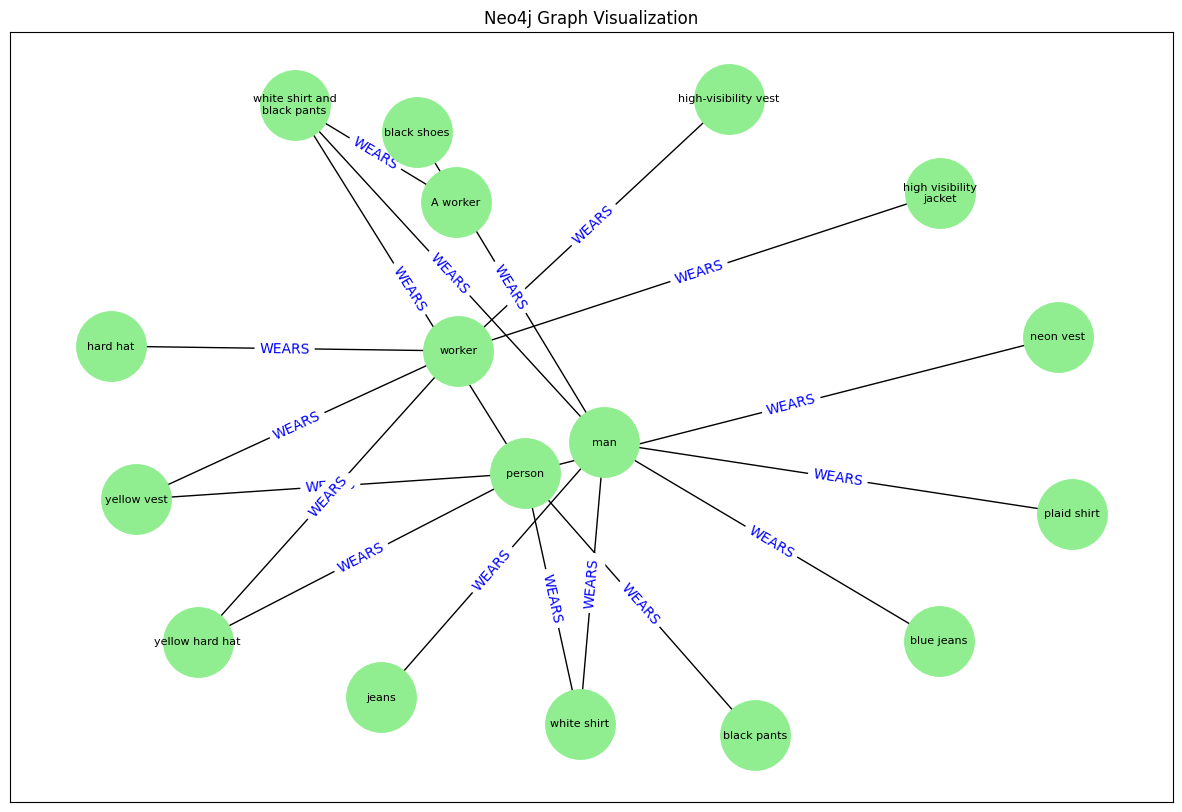

In [17]:
visualize_neo4j_query("MATCH p=()-[r:WEARS]->() RETURN p")

#### Visualizing Sub-Graph where a Person with id='worker' carries an item

The following Cypher query retrieves information about a specific person (identified by `worker`) who has carries an item. It matches the `CARRIES` relationship between the person and the item, returning the path and details of the action.

**Cypher Query:**

```cypher
MATCH p=(person)-[r:CARRIES]->(item)
WHERE person.id = 'worker'
RETURN p
```


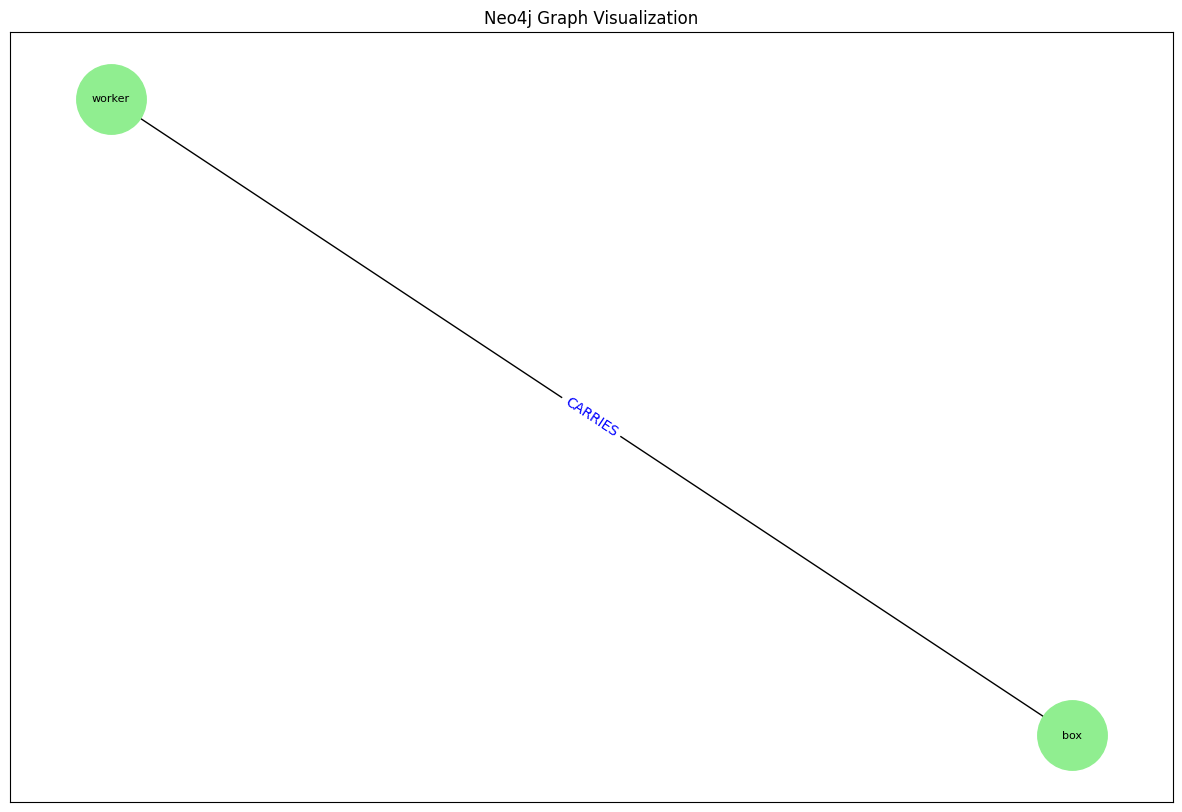

In [18]:
visualize_neo4j_query("MATCH p=(person)-[r:CARRIES]->(item) WHERE person.id = 'worker' RETURN p")

#### Fetching a particular node with Cypher Query

Let's see how our system would answer "Describe the person who was carrying the box." which we asked before.

The following Cypher query retrieves information about people who carried an item with the `id` of "box". It matches the `CARRIES` relationship between a person and the item, and returns the details of the person and the item they carried.

**Cypher Query:**

```cypher
MATCH p=(person)-[r:CARRIES]->(item)
WHERE item.id = "box"
RETURN p
```

In [19]:
query = """
MATCH p=(person)-[r:CARRIES]->(item)
WHERE item.id = "box"
RETURN p
"""

text_output = get_neo4j_query_text(query)
print(text_output)

Person: person placed an item: box
Person: worker placed an item: box
Person: man placed an item: box


## Next

Congratulations! This concludes the final lab of the course. Time to put this knowledge to the test in a final assessment. Best of luck!

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>